In [36]:
import os
import sys
import random 

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt 
import albumentations as albu

sys.path.append("..")

from IPython import display

# %load_ext autoreload
# %autoreload 2

In [2]:
# sys.path.append("/home/zakirov/repoz/metrics-comparison/")
# sys.path.append("../")

## Download datasets

In [3]:
# mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
# cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
# cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)
# fashin_mnist = torchvision.datasets.FashionMNIST("datasets", download=True)

In [4]:
# !wget -P datasets/ http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !wget -P datasets/ http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip
# !wget -P datasets/ http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
# !wget -P datasets/ http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# !wget -P datasets/ http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip

## Test datasets

In [37]:
from src.augmentations import get_aug
from src.utils import walk_files
from src.datasets import *
from torch.utils.data import Dataset

In [6]:
task = "denoise"
transform = get_aug(aug_type="light", task=task, dataset="mnist", size=28)
mnist = MNIST(root="datasets/", train=True, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="fashionmnist", size=28)
fashionmnist = FashionMNIST(root="datasets/", train=True, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="cifar10", size=32)
cifar10 = CIFAR10(root="datasets/", train=True, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="cifar100", size=32)
cifar100 = CIFAR100(root="datasets/", train=True, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="tinyimagenet", size=64)
tiny = TinyImageNet(train=True, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="div2k", size=128)
div2k = DIV2K(train=True, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="set5", size=128)
set5 = Set5(train=False, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="set14", size=128)
set14 = Set14(train=False, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="urban100", size=128)
urban100 = Urban100(train=False, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="manga109", size=128)
manga109 = Manga109(train=False, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="coil100", size=128)
coil100 = COIL100(train=False, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="bsds100", size=128)
bsds100 = BSDS100(train=False, transform=transform)

transform = get_aug(aug_type="light", task=task, dataset="medicaldecathlon", size=256)
medicaldecathlon = MedicalDecathlon(train=False, transform=transform)

In [7]:
datasets = [
    mnist, 
    fashionmnist,
    cifar10, 
    cifar100,
    tiny, 
    div2k, 
    set5, 
    set14,
    urban100, 
    manga109, 
    coil100, 
    bsds100,
    medicaldecathlon,
]

In [8]:
# total_mean, total_var = [], []
# for i in range(len(div2k)):
#     image = div2k[i][1]
#     total_mean.append(image.mean(dim=[1,2]))
#     total_var.append(image.var(dim=[1,2]))
# print(torch.stack(total_mean).mean(dim=0))
# print(torch.stack(total_var).mean(dim=0))



In [35]:
a = {"a": 2, "b":3}
a. ("a")
a

{'b': 3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input torch.Size([3, 128, 128]) tensor(-0.8588) tensor(1.)
Target torch.Size([3, 128, 128]) tensor(-0.8196) tensor(1.)


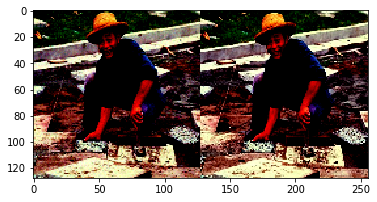

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input torch.Size([3, 256, 256]) tensor(-0.9916, dtype=torch.float64) tensor(3.7053, dtype=torch.float64)
Target torch.Size([3, 256, 256]) tensor(-0.9916, dtype=torch.float64) tensor(3.7672, dtype=torch.float64)


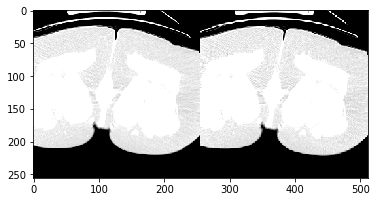

In [13]:
for dataset in datasets[-2:]:
    print(dataset)
    input, target = dataset[0]
    print("Input", input.shape, input.min(), input.max())
    print("Target", target.shape, target.min(), target.max())
    input = input.unsqueeze(0)
    input = F.interpolate(input, size=target.shape[-2:])
    input.squeeze_()
    plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0))
    plt.show()
    

In [38]:
# Get dataset with no transform
medicaldecathlon = MedicalDecathlon(train=False, transform=None)
image = medicaldecathlon[0][0]
image.shape

(384, 384, 3)

In [46]:
image[...,0].shape

(384, 384)

In [39]:
import albumentations as albu
import albumentations.pytorch as albu_pt

mean, std, max_value = (0.0, 0.0, 0.0), (1.0, 1.0, 1.0), 1024.

NORM_TO_TENSOR = albu.Compose([
    albu.Normalize(mean=mean, std=std, max_pixel_value=max_value),
    #  albu.Normalize(mean=mean, std=std, max_pixel_value=max_value),
    albu_pt.ToTensorV2()],
    additional_targets={"mask": "image"})

In [48]:
# idx = 356
image[..., 0].min(), image[..., 0].max(), image[...,0].mean()
# plt.hist()
# print(image.min(), image.max(), image.mean())
# augmented = NORM_TO_TENSOR(image=image, mask=image)
# input, target = augmented["image"], augmented["mask"]


(-1024.0, 1272.0, -235.29436577690973)

In [43]:
plt.imshow((medicaldecathlon[idx][0][..., 0]))

IndexError: index 356 is out of bounds for axis 0 with size 270

In [26]:
a = np.random.rand(256, 256)
a = a[:,:,np.newaxis].repeat(3, axis=2)
# a.repeat(3, axis=0).shape

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


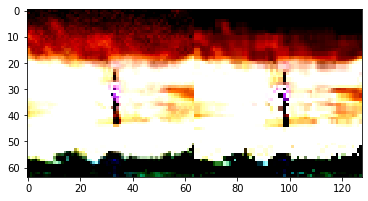

In [24]:
plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0)[:, :, [2, 1, 0]])

## Test dataloaders

In [4]:
from src.datasets import get_dataloader

In [5]:
datasets = ["mnist", "cifar10", "cifar100", "tinyimagenet", "div2k"]
transform = get_aug(aug_type="light", task="deblur", size=128)

for dataset in datasets:
    train_loader = get_dataloader(dataset, transform, train=True)
    val_loader = get_dataloader(dataset, transform, train=False)


Using datasets: mnist. Train size: 60000.

Using datasets: mnist. Validation size: 10000.

Using datasets: cifar10. Train size: 50000.

Using datasets: cifar10. Validation size: 10000.

Using datasets: cifar100. Train size: 100000.

Using datasets: cifar100. Validation size: 20000.

Using datasets: tinyimagenet. Train size: 100000.

Using datasets: tinyimagenet. Validation size: 10000.

Using datasets: div2k. Train size: 800.

Using datasets: div2k. Validation size: 100.


In [27]:
import photosynthesis_metrics as pm
image_metrics = ["kid", {}, "ssim", {}, ]

METRIC_FROM_NAME = {
    "ssim" : pm.SSIMLoss,
    "ms-ssim" : pm.MultiScaleSSIMLoss,
    "msid" : pm.MSID,
    "fid" : pm.FID,
    "kid" : pm.KID,
#     "content" : ContentLoss,
#     "style" : StyleLoss,
    "tv" : pm.TVLoss,
}


# for metric in image_metrics:
image_metrics = [METRIC_FROM_NAME[metric](**kwargs) for metric, kwargs in zip(image_metrics[::2], image_metrics[1::2])]
# list(zip(image_metrics[::2], image_metrics[1::2]))
image_metrics

[KID(), SSIMLoss()]

In [30]:
from collections import OrderedDict
output = OrderedDict({
    'loss': 1,
#     'mse': mse,
#     'psnr': psnr,
#     'ssim': ssim_score,
#     # 'val_ms_ssim': ms_ssim_score,
#     'input_features': input_features,
#     'target_features': target_features
})
output["test"] = 3
output["foo"] = "bar"

'bar'

In [ ]:
# from functools import b
# 
iter()

In [38]:
a = ["foo", "bar"]
if "foo" in a:
    print(a.index("foo"))
# a.append("loss")
# print(a)
# a.pop()
# a
# for i in "etc", a:
#     print(i)

0


In [8]:
features = make_layers(
    [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"], 
    batch_norm=True
)
vgg_16 = VGG(features)

In [9]:
vgg_16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [12]:
x = torch.rand(10, 3, 224, 224)
layers = None
if layers is None:
    layers = ["0", "5", "10", "19", "28"]

features = []
for name, module in vgg_16.features._modules.items():
    x = module(x)
    if name in layers:
        features.append(x)


In [13]:
features

[tensor([[[[-7.8670e-02, -1.6354e-01, -1.2225e-01,  ..., -1.4535e-01,
            -1.4584e-01, -1.6412e-01],
           [-1.6184e-01, -2.3506e-01, -3.1266e-01,  ..., -2.0155e-01,
            -2.6703e-01, -3.7117e-02],
           [-3.3386e-01, -3.5759e-01, -4.1006e-01,  ..., -3.3040e-01,
            -2.0890e-01, -2.0440e-01],
           ...,
           [-2.2252e-01, -2.0513e-01, -3.3348e-01,  ..., -3.6601e-01,
            -3.3097e-01, -1.7747e-01],
           [-2.3798e-01, -2.9009e-01, -3.2904e-01,  ..., -2.8494e-01,
            -1.1763e-01, -1.4277e-01],
           [-1.4894e-01, -5.6518e-02, -1.3160e-01,  ..., -8.2170e-02,
            -2.6207e-01,  3.9249e-02]],
 
          [[ 2.9822e-02, -3.8332e-02,  5.3954e-03,  ...,  1.5230e-01,
             4.5484e-03,  4.9021e-02],
           [-7.7623e-02, -9.5545e-02,  3.3520e-02,  ..., -1.7780e-02,
             5.4646e-02,  2.8361e-03],
           [ 1.0605e-02, -1.2710e-01, -1.5536e-01,  ..., -6.8971e-03,
            -8.9209e-02,  1.6279e-03],


In [9]:
# from albumentations import ImageOnlyTransform
albu.ImageCompression()

In [112]:
target.permute(2, 0, 1).shape, input.shape

(torch.Size([3, 512, 512]), torch.Size([3, 512, 512]))

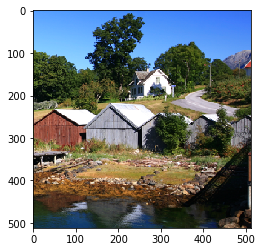

In [113]:
plt.imshow(target.permute(2, 0, 1).transpose(0, 2).transpose(0, 1))

In [70]:
dataset = TinyImageNetDataset(train=True, transform=None, target_transform=None)
input, target = dataset[6]
# input.shape
# plt.imshow(input / 255.)
(input / 255.).min(), (input / 255.).max()

(0.0, 1.0)

In [46]:
input.transpose(0, 2).transpose(0, 1).shape

torch.Size([64, 64, 3])

In [37]:
# dataset[0][0].shape

(64, 64, 3)

In [7]:
# from src.augmentations import get_aug
# from src.datasets import MNIST, CIFAR10, CIFAR100
from ..src.datasets
# from src.datasets import get_dataloader

ModuleNotFoundError: No module named 'src.datasets'

In [ ]:
transform = get_aug(aug_type="light", size=32)
target_transform = get_aug(aug_type="val", size=32)
# target_transform = None

In [ ]:
transform, target_transform

In [ ]:
trainset = CIFAR10(root='../datasets', train=True, transform=transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# valset = CIFAR10(root='../datasets', train=False, transform=transform, target_transform=target_transform)
# valloader = torch.utils.data.DataLoader(valset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
image, target = trainset[0]
print(image.shape, target.shape)
print(image.max(), image.min())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
input, target = dataiter.next()

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Identity()
model.to("cpu")

In [ ]:
mock = torch.rand((3, 3, 32, 32))

In [ ]:
result = model(mock)

In [ ]:
all_input_features = [result.detach() for _ in range(4)]
print(len(all_input_features))

In [ ]:
input_features = torch.cat(all_input_features, dim=0)
input_features.shape

In [ ]:
input.shape, target.shape

In [ ]:
class HDRLoss(nn.Module):
    """High dynamic range loss."""

    def __init__(self, eps=0.01):
        """Initializes loss with numerical stability epsilon."""

        super(HDRLoss, self).__init__()
        self._eps = eps


    def forward(self, denoised, target):
        """Computes loss by unpacking render buffer."""

        loss = ((denoised - target) ** 2) / (denoised + self._eps) ** 2
        return loss.mean(dim=[1,2,3])

In [ ]:
hdr = HDRLoss()

In [ ]:
loss = hdr(target+ 0.001, target)
print(loss.shape)

In [ ]:
loss

In [ ]:
# show images
print(images.shape)
grid = torchvision.utils.make_grid(images[:16])
print(grid.shape)
imshow(grid)

In [ ]:
imshow(torchvision.utils.make_grid(target))

In [ ]:

# plt.imshow(image[:, :, 0])

In [ ]:
import photosynthesis_metrics as pm

In [6]:
import h5py

In [77]:
datapath = "datasets/decathlon/colon.h5"
with h5py.File(datapath, "r") as f:
    for key in f.keys():
        print(key)
#     data_val = f['imgs_validation'][::10]
#     data_test = f['imgs_testing'][::10]
#     data = np.concatenate((data_val, data_test))
#     print(data.shape)
#     print(len(data))
    

# hf = 
# data_numpy = np.zeros(hf['imgs_train'].shape, dtype=numpy_type)
# # hf['dataset_name'].read_direct(n1)
# # hf.close()

description
imgs_testing
imgs_train
imgs_validation
license
modalities
msks_testing
msks_train
msks_validation
name
reference
release
tensorImageSize
testing_input_files
testing_label_files
training_input_files
training_label_files
validation_input_files
validation_label_files


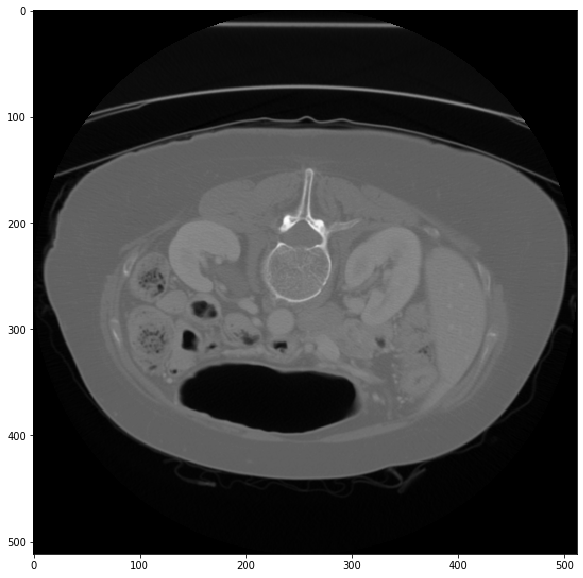

In [103]:
data = hf['imgs_train'][5000]
mask = hf['msks_train'][5000]
plt.figure(figsize=(10, 10))
plt.imshow(data.squeeze(), cmap='gray')
# plt.imshow(mask.squeeze(), alpha=0.1)
# data.max()


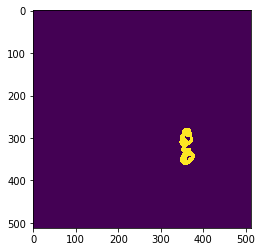

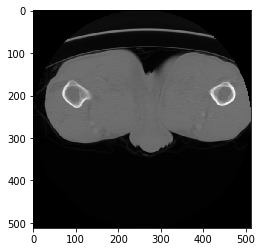

In [41]:
# data.max()


<HDF5 dataset "imgs_train": shape (10578, 512, 512, 1), type "<f8">